In [417]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pylab as plt
import re
import scipy as sp
from sklearn.preprocessing import StandardScaler

# 1. clicks 모델링 with training_set

In [418]:
train = pd.read_csv('training_set.csv', encoding='CP949')
test = pd.read_csv('test_set.csv', encoding='CP949')

# 전처리

In [419]:
print len(train[train['language_code'] == 'ko'])
print len(train[train['language_code'] == 'en'])

7783
1753


In [420]:
ko_X1 = pd.DataFrame(train[train['language_code'] == 'ko'],columns = ['id','comments_count','likes_count','clippings_count','via','category','communities'])
en_X1 = pd.DataFrame(train[train['language_code'] == 'en'],columns = ['id','comments_count','likes_count','clippings_count','via','category','communities'])

In [421]:
y1 = pd.DataFrame(train[train['language_code'] == 'ko'], columns = ['clicks_count'])

In [422]:
ko_X1 = ko_X1.drop(ko_X1.index[[755,1149,2237,5310,6579,7728]]).reset_index(drop=1)
y1 = y1.drop(y1.index[[755,1149,2237,5310,6579,7728]]).reset_index(drop=1)

In [423]:
via_dum = pd.DataFrame(np.zeros((len(ko_X1),3)),columns = ['android','ios','web'])
for i, via in enumerate(ko_X1.via):
    if via == 'android':
        via_dum.ix[i, 0] = 1
    elif via == 'ios':
        via_dum.ix[i,1] = 1
    elif via == 'web':
        via_dum.ix[i,2] = 1
ko_X1 = ko_X1.join(via_dum)

In [424]:
category_dum = pd.DataFrame(np.zeros((len(ko_X1),2)),columns = ['ImagePost','TextPost'])
for i, category in enumerate(ko_X1.category):
    if category == 'ImagePost':
        category_dum.ix[i,0] = 1
    elif category == 'TextPost':
        category_dum.ix[i,1] = 1
ko_X1 = ko_X1.join(category_dum)

In [425]:
community = ['그래픽 디자인','자전거','한국 TV쇼','뉴스와 이슈','야구','한국 드라마','남성 패션','맛집 탐방','부모','축구','유머','모바일 게임','홈 인테리어 & 데코','요리','자동차','캠핑','웹툰','일본 애니메이션','동물','피트니스','다이어트','금융','사진 예술','일러스트레이션','책','한국 여행','남성 데일리룩','디아이와이','영감을 주는 이야기','국내 연예','음식','빙글러','Did You Know?','아시아의 미녀스타','어록','남성 스트리트 패션','고양이','한국 가요','결혼 생활','한국 음식','공포 미스테리','헤어스타일','모델', '기업가정신','남성 신발','술','마케팅','스킨케어','한국 영화','엽기','창작문예','디저트','인터넷 스타','강연','스포츠','요가','코리안 뷰티','게임','네일','맥주','카페','필라테스','대학 생활','영아(2세미만 부모)','역사','패션 디자인','유럽 여행','유아(2~4세 부모)','인테리어 디자인','축제','무한 도전','웨딩&허니문','시','헐리우드 영화','향수','가구','임신과 출산','별자리 운세','일본 만화','커피','재테크','크로스핏','꽃','맨즈 그루밍','호텔&숙소','퓨전 요리','베이킹','카메라','이벤트/세일 정보','미국 여행','일본 여행','남성 액세서리','애플','모바일 앱','수공예','댄스','자연 ','PC 게임','원피스(만화)','음악 페스티벌','부산 여행','순수 예술','무술','여성 액세서리','프리미어리그','남성 시계','익스트림 스포츠','스파&마사지','비디오 게임','천문학','음료','자동차 튜닝','현대 미술','인디음악','채식요리','팬 아트 (Fan Art)','헐리우드 스타','여성 슈즈','키덜트 제품','과학','일본어 공부','어쿠스틱','아동 패션','건축','의료','인형','산업 디자인','일렉트로닉 뮤직','남성 스포츠웨어','남성 가방','오피스 인테리어','아시아 남자 스타','뮤지컬','일기','미니어처','토이','악기','Social Media','홍콩 여행','호주 여행','뜨개질','흑백사진','와인','연극','일본 영화','전시회','스킨 스쿠버 다이빙','목공예','중국 여행','중국어 공부','수상 스포츠','차','태국 여행','레고','푸드 스타일링','메이저리그','원예','농구','하이킹&트레킹','픽시','성형수술','공유경제','여성 가방','일본 스타','컴퓨터','일본 음식','여성 스포츠웨어','힙합','빅토리아시크릿 모델','빅토리아 시크릿','그릇 및 조리도구','액션 영화','팝 뮤직','파리 여행','한국 만화','액션 게임','클럽음악','시뮬레이션 게임','중국 음식','사회적 기업','복싱','오토바이','캐나다 여행','가젯','도쿄 여행','인포그래픽','드레스','이탈리아 여행','방콕 여행','미국 드라마','에이오에이','케이크','이탈리아 음식','중국 스타','에이핑크','유럽 건축','야생동물','브라운 아이드 걸스','UEFA 챔피언스 리그','한지민','나이키','런던 여행','브레인 티저','맨체스터 유나이티드','월페이퍼','아디다스','여성 시계','안경류','웹&모바일 디자인','프랑스 여행','영국 여행','교토 여행','홈엔터테인먼트','디제이','영국 여행','아이유','바르셀로나 여행','라리가','현아(포미닛)','코스프레','FPS 게임','발라드','아이폰 앱','안드로이드 앱','어드벤쳐 게임','손예진','로마 여행','일본 드라마','주스&스무디','스트리트 아트','걸스데이','피렌체 여행','필리핀 여행','롤플레잉 게임','도시락','현대 자동차','UEFA 유로파 리그','미국 애니메이션','모던 패밀리(미국 드라마)','프렌즈 (미국 시트콤)','골프','해산물','분데스리가','스포츠 게임','설리(f(x))','NCIS(미국 드라마)','로스트(미국 드라마)','미국 정치','박보영','K리그 클래식','몰디브 여행','칵테일','엔비에이','신민아','꽃보다 남자','밀리터리 매니아','기아 자동차','김건모','대만스타','액션 피규어','대구 FC','한국 건축','씨스타','독일 여행','한옥','스페인 여행','패키지 디자인','물고기(애완동물)','e스포츠','싸이']

In [426]:
community_dum = pd.DataFrame(np.zeros((len(ko_X1),len(community))),columns = community)
for i, communities in enumerate(ko_X1.communities):
    try:
        l = re.sub(r'[{}]','',communities)
        l = re.split(',',l)
        for c in l:
            c = c.encode('utf-8')
            if c in community:
                community_dum.ix[i,c] = 1
    except:
        pass

In [427]:
co = np.arange(len(community))
community_dum.columns = co
ko_X1 = ko_X1.join(community_dum.add_prefix('Community_'))

# OLS 모델링

In [428]:
ko_X1.columns

Index([u'id', u'comments_count', u'likes_count', u'clippings_count', u'via',
       u'category', u'communities', u'android', u'ios', u'web',
       ...
       u'Community_260', u'Community_261', u'Community_262', u'Community_263',
       u'Community_264', u'Community_265', u'Community_266', u'Community_267',
       u'Community_268', u'Community_269'],
      dtype='object', length=282)

In [429]:
ko_X2 = pd.DataFrame(ko_X1, columns = ['comments_count','likes_count','android','ImagePost','TextPost','Community_2','Community_3','Community_9','Community_10','Community_16','Community_18','Community_28','Community_29','Community_31','Community_32','Community_33','Community_36','Community_40','Community_49','Community_50','Community_52','Community_53','Community_54','Community_59','Community_101','Community_138','Community_141','Community_152','Community_167','Community_190','Community_204','Community_221'])
ko_X2 = sm.add_constant(ko_X2)

In [430]:
model = sm.OLS(y1, ko_X2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           clicks_count   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     554.3
Date:                Sun, 14 May 2017   Prob (F-statistic):               0.00
Time:                        09:10:36   Log-Likelihood:                -72454.
No. Observations:                7777   AIC:                         1.450e+05
Df Residuals:                    7745   BIC:                         1.452e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -24.0422     55.692     -0.

# 아웃라이어 제거

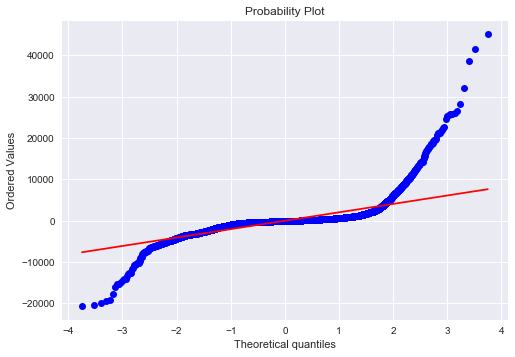

In [431]:
sp.stats.probplot(result.resid, plot = plt)
plt.show()

In [432]:
influence = result.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 /float(len(ko_X2)-2)
idx = np.where(cooks_d2 < fox_cr)[0]
ko_X3 = ko_X2.ix[idx,:].reset_index(drop = 1)
y3 = y1.ix[idx,:].reset_index(drop = 1)

In [433]:
model2 = sm.OLS(y3, ko_X3)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:           clicks_count   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     1216.
Date:                Sun, 14 May 2017   Prob (F-statistic):               0.00
Time:                        09:10:37   Log-Likelihood:                -61686.
No. Observations:                7320   AIC:                         1.234e+05
Df Residuals:                    7290   BIC:                         1.236e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -23.3309     23.255     -1.

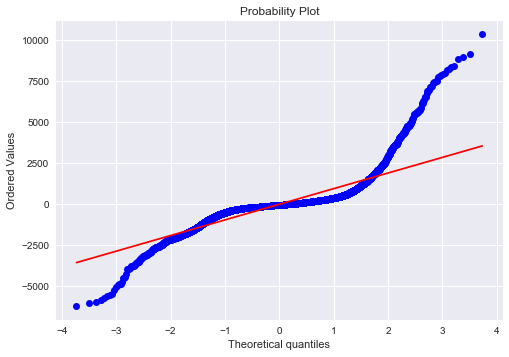

In [434]:
plt.figure()
sp.stats.probplot(result2.resid, plot = plt)
plt.show()

In [435]:
print len(ko_X2)-len(ko_X3)

457


# 변수 선택

In [436]:
ko_X4= ko_X3.copy()
y4 = y3.copy()

In [437]:
del ko_X4['Community_53']
del ko_X4['Community_59']
del ko_X4['Community_138']
del ko_X4['Community_141']
del ko_X4['Community_167']
del ko_X4['Community_190']
del ko_X4['Community_204']
del ko_X4['TextPost']

In [438]:
model3 = sm.OLS(y4, ko_X4)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:           clicks_count   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     1469.
Date:                Sun, 14 May 2017   Prob (F-statistic):               0.00
Time:                        09:10:37   Log-Likelihood:                -61688.
No. Observations:                7320   AIC:                         1.234e+05
Df Residuals:                    7295   BIC:                         1.236e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -96.0394     61.355     -1.

# 스케일링

In [439]:
ko_X5 = ko_X4.copy()
y5 = y4.copy()

In [440]:
ko_X5.columns

Index([u'const', u'comments_count', u'likes_count', u'android', u'ImagePost',
       u'Community_2', u'Community_3', u'Community_9', u'Community_10',
       u'Community_16', u'Community_18', u'Community_28', u'Community_29',
       u'Community_31', u'Community_32', u'Community_33', u'Community_36',
       u'Community_40', u'Community_49', u'Community_50', u'Community_52',
       u'Community_54', u'Community_101', u'Community_152', u'Community_221'],
      dtype='object')

In [441]:
scaler = StandardScaler()

In [442]:
ko_X6 = pd.DataFrame(scaler.fit_transform(ko_X5.ix[:, 1:3]), columns=ko_X5.columns[1:3])
y6  = pd.DataFrame(scaler.fit_transform(y5), columns= y5.columns)

In [443]:
ko_X6= ko_X6.join(ko_X5.reset_index(drop=1).ix[:,3:])

In [444]:
ko_X6 = sm.add_constant(ko_X6, has_constant='add')
ko_X6.columns

Index([u'const', u'comments_count', u'likes_count', u'android', u'ImagePost',
       u'Community_2', u'Community_3', u'Community_9', u'Community_10',
       u'Community_16', u'Community_18', u'Community_28', u'Community_29',
       u'Community_31', u'Community_32', u'Community_33', u'Community_36',
       u'Community_40', u'Community_49', u'Community_50', u'Community_52',
       u'Community_54', u'Community_101', u'Community_152', u'Community_221'],
      dtype='object')

# 최종 모형

In [445]:
model4 = sm.OLS(y6.reset_index(drop = 1), ko_X6)
result4 = model4.fit()
print(result4.summary())

                            OLS Regression Results                            
Dep. Variable:           clicks_count   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     1469.
Date:                Sun, 14 May 2017   Prob (F-statistic):               0.00
Time:                        09:10:38   Log-Likelihood:                -3932.7
No. Observations:                7320   AIC:                             7915.
Df Residuals:                    7295   BIC:                             8088.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.1118      0.023     -4.

# 교차 검증

In [446]:
X = ko_X6.ix[:,1:].values
y = y6.values

In [447]:
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
model5 = LinearRegression()
cv = KFold(len(ko_X6), n_folds=5, random_state=0)

scores = np.zeros(5)
for i, (train_index, test_index) in enumerate(cv):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    model5.fit(X_train, y_train)
    y_pred = model5.predict(X_test)
    scores[i] = r2_score(y_test, y_pred)

scores

array([ 0.80569784,  0.83786815,  0.78693992,  0.83171389,  0.85654393])

In [448]:
scores.mean()

0.82375274495231532

# 2. 예측 with test_set

In [483]:
test.shape

(150, 21)

In [484]:
test_X = pd.DataFrame(test[test['language_code'] == 'ko'],columns = ['id','comments_count','likes_count','via','category','communities'])

In [485]:
test_X = test_X.reset_index(drop = 1)

In [486]:
test_X.shape

(118, 6)

In [487]:
via_dum = pd.DataFrame(np.zeros((len(test_X),3)),columns = ['android','ios','web'])
for i, via in enumerate(test_X.via):
    if via == 'android':
        via_dum.ix[i, 0] = 1
    elif via == 'ios':
        via_dum.ix[i,1] = 1
    elif via == 'web':
        via_dum.ix[i,2] = 1
test_X = test_X.join(via_dum)

In [488]:
category_dum = pd.DataFrame(np.zeros((len(test_X),2)),columns = ['ImagePost','TextPost'])
for i, category in enumerate(test_X.category):
    if category == 'ImagePost':
        category_dum.ix[i,0] = 1
    elif category == 'TextPost':
        category_dum.ix[i,1] = 1
test_X = test_X.join(category_dum)

In [489]:
community_dum = pd.DataFrame(np.zeros((len(test_X),len(community))),columns = community)
for i, communities in enumerate(test_X.communities):
    try:
        l = re.sub(r'[{}]','',communities)
        l = re.split(',',l)
        for c in l:
            c = c.encode('utf-8')
            if c in community:
                community_dum.ix[i,c] = 1
    except:
        pass

In [490]:
co = np.arange(len(community))
community_dum.columns = co
test_X = test_X.join(community_dum.add_prefix('Community_'))

In [491]:
test_X.columns

Index([u'id', u'comments_count', u'likes_count', u'via', u'category',
       u'communities', u'android', u'ios', u'web', u'ImagePost',
       ...
       u'Community_260', u'Community_261', u'Community_262', u'Community_263',
       u'Community_264', u'Community_265', u'Community_266', u'Community_267',
       u'Community_268', u'Community_269'],
      dtype='object', length=281)

In [492]:
test_X2 = pd.DataFrame(test_X, columns = ['const','comments_count','likes_count','android','ImagePost','Community_2','Community_3','Community_9','Community_10','Community_16','Community_18','Community_28','Community_29','Community_31','Community_32','Community_33','Community_36','Community_40','Community_49','Community_50','Community_52','Community_54','Community_101','Community_152','Community_221'])

In [493]:
test_X3 = pd.DataFrame(scaler.transform(test_X2.ix[:, 1:3]), columns=test_X2.columns[1:3])

In [494]:
test_X3= test_X3.join(test_X2.reset_index(drop=1).ix[:,3:])

In [495]:
test_X3 = sm.add_constant(test_X3, has_constant='add')
test_X3.columns

Index([u'const', u'comments_count', u'likes_count', u'android', u'ImagePost',
       u'Community_2', u'Community_3', u'Community_9', u'Community_10',
       u'Community_16', u'Community_18', u'Community_28', u'Community_29',
       u'Community_31', u'Community_32', u'Community_33', u'Community_36',
       u'Community_40', u'Community_49', u'Community_50', u'Community_52',
       u'Community_54', u'Community_101', u'Community_152', u'Community_221'],
      dtype='object')

In [482]:
#test_id = test_X3['id']

In [496]:
pred = result4.predict(test_X3)

In [497]:
y = scaler.inverse_transform(pred)

In [498]:
print y

[   20.21076719  1706.42854783    38.20708686   624.09234766   901.89840171
   242.65149587   143.73641186     9.05671354  1730.36657081    12.8588662
   890.62359512    13.61929673     9.14138457   152.69223618  2040.03730988
   143.65174082  -185.87486312   -92.90829222   141.28577819  -110.77765233
     9.05671354    22.21184286   187.04606057   413.19415544  2136.53053398
 -1550.55566774   514.1350702  -1390.61241979  -322.66651097  4680.95827594
   144.15976702  -318.86435831  -166.94598516     9.9018151    141.79541316
     9.05671354   140.52534766  -316.58306671   187.63714904   -11.39897677
  1585.50497394    17.42144939   141.28577819  3078.97339889  -151.47408424
  -480.67427965  4261.08151919  -719.6284677   4954.5094657    143.65174082
   146.86280502   140.52534766     7.53585247  -278.47686907  -427.8163781
   142.80663926    22.21184286   217.87144408  -451.51163072    14.46439829
  2187.06245955  -322.66651097  1278.61941698    30.60278154     7.53585247
    25.0257547

In [499]:
pd.DataFrame(y).describe()

,0
count,118.000000
mean,359.209148
std,1278.886066
min,-2000.223666
25%,-151.338051
50%,23.618799
75%,210.312870
max,4955.608580


In [500]:
train['clicks_count'].describe()

count     9789.000000
mean      1509.723056
std       4364.864121
min          0.000000
25%         55.000000
50%        186.000000
75%        701.000000
max      69951.000000
Name: clicks_count, dtype: float64

# 예측 결과

In [501]:
test_id = pd.DataFrame(test_id)
y = pd.DataFrame(y)
result = pd.concat([test_id ,y],axis = 1)

In [502]:
result

,id,0
0,2054531,20.210767
1,2054593,1706.428548
2,2054646,38.207087
3,2051444,624.092348
4,2051474,901.898402
5,2054690,242.651496
6,2051536,143.736412
7,2051545,9.056714
8,2051550,1730.366571
9,2054836,12.858866


In [503]:
result2 = result.sort(0 , ascending=False)

c:\python27\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


In [504]:
result2.head()

,id,0
77,2051968,4955.608580
48,2052081,4954.509466
70,2051846,4884.548248
29,2052883,4680.958276
46,2052024,4261.081519


In [505]:
result2.tail()

,id,0
79,2056937,-1519.037723
25,2050126,-1550.555668
95,2053630,-1558.920404
112,2056186,-1720.846584
92,2052606,-2000.223666
